In [1]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY'] ['HPC']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [0] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,120]] #[[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [3]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    start_cutoff = 0 # in samples
    if encoding_mode == 1: # raw is from -1.7 to 3.3 s from word_on
        saveName = 'encoding_'
        recall_str = ''
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        end_cutoff = 2500 # just take the whole range of data to better estimate Morlet     
 
    elif encoding_mode == 0: # raw is from -3 to 3 s from recall
        saveName = 'recall_'
        recall_str = '_recall'
        end_cutoff = 3000 # just take the whole range of data to better estimate Morlet       

    sr_factor = 1000/fs
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1
order: C
Generating figures for run_mode:  0


In [4]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'clust', 'raw', 'elec_by_elec_correlation', 'serial_pos', 'recall_pos', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'clust_int'])

(23462, 2000)

(23462, 3000)

(2, 23462, 300)

[[33.5, 75], [80, 120]]

array(['R1004D', 'R1015J', 'R1024E', 'R1031M', 'R1032D', 'R1035M',
       'R1045E', 'R1061T', 'R1065J', 'R1066P', 'R1086M', 'R1089P',
       'R1092J', 'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1131M',
       'R1138T', 'R1144E', 'R1147P', 'R1157C', 'R1158T', 'R1163T',
       'R1171M', 'R1174T', 'R1176M', 'R1188C', 'R1192C', 'R1201P',
       'R1204T', 'R1207J', 'R1217T', 'R1226D', 'R1228M', 'R1230J',
       'R1236J', 'R1243T', 'R1245E', 'R1254E', 'R1260D', 'R1261P',
       'R1269E', 'R1271P', 'R1275D', 'R1278E', 'R1279P', 'R1293P',
       'R1310J', 'R1313J', 'R1315T', 'R1330D', 'R1332M', 'R1338T',
       'R1342M', 'R1343J', 'R1348J', 'R1354E', 'R1366J', 'R1367D',
       'R1368T', 'R1374T', 'R1376D', 'R1382T', 'R1383J', 'R1385E',
       'R1387E', 'R1388T', 'R1396T', 'R1397D', 'R1398J', 'R1413D',
       'R1445E', 'R1448T', 'R1449T', 'R1456D', 'R1465D', 'R1468J',
       'R1472T', 'R1476J', 'R1486J', 'R1488T', 'R1497T', 'R1501J',
       'R1515T', 'R1518T', 'R1525J', 'R1527J', 'R1533J', 'R153

In [17]:
gamma_sd_thresh = 1.5
remove_first_recalls = 0 # if looking at recall might want to remove first recall of each list

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    else:
        final_sub_idxs = (sub_idxs) & (clust!=0)
else:
    final_sub_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][final_sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
if power_z.ndim == 2:
    power_z = power_z[np.newaxis, :, :]
sub_Zs = power_z[:,final_sub_idxs,:]
sub_clust_ID = clust[final_sub_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # # note only +700 since ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((2700+ripple_analysis_start)/z_factor),int((2700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s   
    
elif encoding_mode == 0:
    ripple_start_offset = -2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((3000+ripple_analysis_start)/z_factor),int((3000+ripple_analysis_end)/z_factor)) # +2000 since goes from -3 to 3 s

# check power > thresh in gamma time range
z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>gamma_sd_thresh
if np.shape(sub_Zs)[0]>1:
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>gamma_sd_thresh     
    
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(final_sub_idxs),2)}% of total')


Number of trials: 23462 from the following subs:


array(['R1004D', 'R1015J', 'R1024E', 'R1031M', 'R1032D', 'R1035M',
       'R1045E', 'R1061T', 'R1065J', 'R1066P', 'R1086M', 'R1089P',
       'R1092J', 'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1131M',
       'R1138T', 'R1144E', 'R1147P', 'R1157C', 'R1158T', 'R1163T',
       'R1171M', 'R1174T', 'R1176M', 'R1188C', 'R1192C', 'R1201P',
       'R1204T', 'R1207J', 'R1217T', 'R1226D', 'R1228M', 'R1230J',
       'R1236J', 'R1243T', 'R1245E', 'R1254E', 'R1260D', 'R1261P',
       'R1269E', 'R1271P', 'R1275D', 'R1278E', 'R1279P', 'R1293P',
       'R1310J', 'R1313J', 'R1315T', 'R1330D', 'R1332M', 'R1338T',
       'R1342M', 'R1343J', 'R1348J', 'R1354E', 'R1366J', 'R1367D',
       'R1368T', 'R1374T', 'R1376D', 'R1382T', 'R1383J', 'R1385E',
       'R1387E', 'R1388T', 'R1396T', 'R1397D', 'R1398J', 'R1413D',
       'R1445E', 'R1448T', 'R1449T', 'R1456D', 'R1465D', 'R1468J',
       'R1472T', 'R1476J', 'R1486J', 'R1488T', 'R1497T', 'R1501J',
       'R1515T', 'R1518T', 'R1525J', 'R1527J', 'R1533J', 'R153

(2, 20818, 300)

7329 trials have ripples which is 35.21% of total


In [18]:
print(f"{len(np.unique(dd_trials['elec_labels'][sub_idxs]))} elecs")
print(f"from {len(np.unique(dd_trials['sess'][sub_idxs]))} sessions")
print(f"from {len(np.unique(dd_trials['subj'][sub_idxs]))} patients")

if region_name == ['ENT']:
    ENT_sess = np.unique(dd_trials['sess'][sub_idxs])
    ENT_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['HPC']:
    HPC_sess = np.unique(dd_trials['sess'][sub_idxs])
    HPC_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['AMY']:
    AMY_sess = np.unique(dd_trials['sess'][sub_idxs])
    AMY_sub = np.unique(dd_trials['subj'][sub_idxs])
    
save_sub_sess_info = 0

if save_sub_sess_info == 1:
    import pickle
    with open('../misc/region_data.pkl', 'wb') as f:
        pickle.dump({
            'ENT_sess': ENT_sess,
            'ENT_sub': ENT_sub,
            'HPC_sess': HPC_sess,
            'HPC_sub': HPC_sub,
            'AMY_sess': AMY_sess,
            'AMY_sub': AMY_sub
        }, f)   

570 elecs
from 189 sessions
from 99 patients


### get start_array!

In [19]:
start_array,_ = getStartEndArrays(sub_ripples)

# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

start array shape: (20818, 1999)


In [20]:
dd_trials.keys()
len(sub_ripples)
gamma_time_range
5*20
95*20

dict_keys(['ripple', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'clust', 'raw', 'elec_by_elec_correlation', 'serial_pos', 'recall_pos', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'clust_int'])

20818

slice(55, 145, None)

100

1900

In [9]:
dd_trials['elec_labels']
len(dd_trials['elec_labels'][final_sub_idxs])
len(dd_trials['subj'][final_sub_idxs])
len(dd_trials['sess'][final_sub_idxs])
np.shape(sub_Zs)
len(sub_clust_ID)

array(['R1108J-1_RU1-RU2', 'R1108J-1_RU3-RU4', 'R1108J-1_RU4-RU5', ...,
       'R1680T-3_LB3-LB4', 'R1680T-3_LB1-LB2', 'R1680T-3_LB3-LB4'],
      dtype='<U24')

20818

20818

20818

(2, 20818, 300)

20818

# plot ripples v. gamma by elec

In [24]:
min_recalls = 25
min_clust_recalls = 10

ripple_time_range = slice( int((-ripple_start_offset+ripple_analysis_start)/sr_factor),
                        int((-ripple_start_offset+ripple_analysis_end)/sr_factor) )
# basically *500 sr divided by 1.8 sec
ripple_hz_conv_factor = (1000/sr_factor) / (sr_factor*(ripple_time_range.stop-ripple_time_range.start)/1000)

sub_elec_labels = dd_trials['elec_labels'][final_sub_idxs]
unique_elecs = np.unique(sub_elec_labels)

# find gamma and ripple rates
sub_ripple_elecs = []; sub_low_gamma_elecs = []; sub_high_gamma_elecs = []
sub_ripple_elecs_clust_diff = []; sub_low_gamma_elecs_clust_diff = []; sub_high_gamma_elecs_clust_diff = []
min_trial_elecs = []
min_trial_clust_elec = []
for elec in unique_elecs:
    elec_idxs = sub_elec_labels==elec
    if sum(elec_idxs) >= min_recalls:
        min_trial_elecs.append(elec)
        sub_ripple_elecs.append(ripple_hz_conv_factor*np.mean(start_array[elec_idxs,ripple_time_range]))
        sub_low_gamma_elecs.append(np.mean(sub_Zs[0,elec_idxs,gamma_time_range]))
        sub_high_gamma_elecs.append(np.mean(sub_Zs[1,elec_idxs,gamma_time_range]))        

        # same but let's find diff b/w clust and unclust recalls
        sub_elec_clust_ID = sub_clust_ID[elec_idxs]
        elec_clustered_full_scope = elec_idxs & (sub_clust_ID>1)
        elec_unclustered_full_scope = elec_idxs & (sub_clust_ID<0)        
        if (sum(sub_elec_clust_ID>1)>=min_clust_recalls) & (sum(sub_elec_clust_ID<0)>=min_clust_recalls):
            min_trial_clust_elec.append(elec)            
            sub_ripple_elecs_clust_diff.append( ripple_hz_conv_factor*\
                                ( np.mean(start_array[elec_clustered_full_scope,ripple_time_range]) - \
                                np.mean(start_array[elec_unclustered_full_scope,ripple_time_range]) ) )
            sub_low_gamma_elecs_clust_diff.append( np.mean(sub_Zs[0,elec_clustered_full_scope,gamma_time_range]) - \
                                                   np.mean(sub_Zs[0,elec_unclustered_full_scope,gamma_time_range]) )
            sub_high_gamma_elecs_clust_diff.append( np.mean(sub_Zs[1,elec_clustered_full_scope,gamma_time_range]) - \
                                                   np.mean(sub_Zs[1,elec_unclustered_full_scope,gamma_time_range]) )       
        
print(f'{len(min_trial_elecs)} of {len(unique_elecs)} elecs survive {min_recalls} min_recalls')
        

351 of 570 elecs survive 25 min_recalls


In [22]:
np.shape(start_array)
ripple_time_range

np.shape(sub_Zs)
gamma_time_range

(20818, 1999)

slice(50, 950, None)

(2, 20818, 300)

slice(55, 145, None)

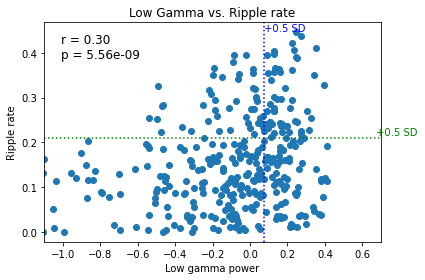

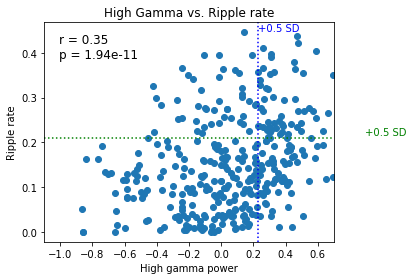

In [33]:
from scipy.stats import pearsonr

num_sd_line = 0.5  # Adjust this value to change the number of SDs

# low gamma vs. ripple rate
correlation_coefficient, p_value = pearsonr(sub_low_gamma_elecs, sub_ripple_elecs)

plt.scatter(sub_low_gamma_elecs, sub_ripple_elecs)
plt.title("Low Gamma vs. Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"

# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_low_gamma_elecs, sub_ripple_elecs, 1)
fit_line = np.array(sub_low_gamma_elecs) * slope + intercept
# plt.plot(sub_low_gamma_elecs, fit_line, color='red', linestyle='--', label='Linear fit')
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')

# Calculate the mean and standard deviation for both variables
mean_low_gamma = np.mean(sub_low_gamma_elecs)
std_low_gamma = np.std(sub_low_gamma_elecs)
mean_ripple = np.mean(sub_ripple_elecs)
std_ripple = np.std(sub_ripple_elecs)

# Plot the ±num_sd_line lines for sub_low_gamma_elecs
ylim = plt.ylim()
plt.axvline(mean_low_gamma + num_sd_line * std_low_gamma, color='blue', linestyle=':', label=f'+{num_sd_line} SD Low Gamma')
plt.text(mean_low_gamma + num_sd_line * std_low_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
         f'+{num_sd_line} SD', color='blue', ha='left', va='bottom')
# plt.axvline(mean_low_gamma - num_sd_line * std_low_gamma, color='blue', linestyle=':', label=f'-{num_sd_line} SD Low Gamma')
# plt.text(mean_low_gamma - num_sd_line * std_low_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
#          f'-{num_sd_line} SD', color='blue', ha='right', va='bottom')
plt.axhline(mean_ripple + num_sd_line * std_ripple, color='green', linestyle=':', label=f'+{num_sd_line} SD Ripple')
plt.text(plt.xlim()[1], mean_ripple + num_sd_line * std_ripple, f'+{num_sd_line} SD', color='green', ha='right', va='bottom')
# plt.axhline(mean_ripple - num_sd_line * std_ripple, color='green', linestyle=':', label=f'-{num_sd_line} SD Ripple')
# plt.text(plt.xlim()[1], mean_ripple - num_sd_line * std_ripple, f'-{num_sd_line} SD', color='green', ha='right', va='top')

plt.xlabel('Low gamma power')
plt.ylabel('Ripple rate')
plt.xlim(-1.1,0.7)
plt.tight_layout(); plt.show()

# high gamma vs. ripple rate
correlation_coefficient, p_value = pearsonr(sub_high_gamma_elecs, sub_ripple_elecs)

plt.scatter(sub_high_gamma_elecs, sub_ripple_elecs)
plt.title("High Gamma vs. Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"

# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_high_gamma_elecs, sub_ripple_elecs, 1)
fit_line = np.array(sub_high_gamma_elecs) * slope + intercept
# plt.plot(sub_high_gamma_elecs, fit_line, color='red', linestyle='--', label='Linear fit')
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')

# Calculate the mean and standard deviation for both variables
mean_high_gamma = np.mean(sub_high_gamma_elecs)
std_high_gamma = np.std(sub_high_gamma_elecs)

# Plot the ±num_sd_line lines for sub_low_gamma_elecs
ylim = plt.ylim()
plt.axvline(mean_high_gamma + num_sd_line * std_high_gamma, color='blue', linestyle=':', label=f'+{num_sd_line} SD Low Gamma')
plt.text(mean_high_gamma + num_sd_line * std_high_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
         f'+{num_sd_line} SD', color='blue', ha='left', va='bottom')
# plt.axvline(mean_high_gamma - num_sd_line * std_high_gamma, color='blue', linestyle=':', label=f'-{num_sd_line} SD Low Gamma')
# plt.text(mean_high_gamma - num_sd_line * std_high_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
#          f'-{num_sd_line} SD', color='blue', ha='right', va='bottom')
plt.axhline(mean_ripple + num_sd_line * std_ripple, color='green', linestyle=':', label=f'+{num_sd_line} SD Ripple')
plt.text(plt.xlim()[1], mean_ripple + num_sd_line * std_ripple, f'+{num_sd_line} SD', color='green', ha='right', va='bottom')
# plt.axhline(mean_ripple - num_sd_line * std_ripple, color='green', linestyle=':', label=f'-{num_sd_line} SD Ripple')
# plt.text(plt.xlim()[1], mean_ripple - num_sd_line * std_ripple, f'-{num_sd_line} SD', color='green', ha='right', va='top')

plt.xlabel('High gamma power')
plt.ylabel('Ripple rate')
plt.xlim(-1.1,0.7)
plt.tight_layout(); plt.show()

a=1;

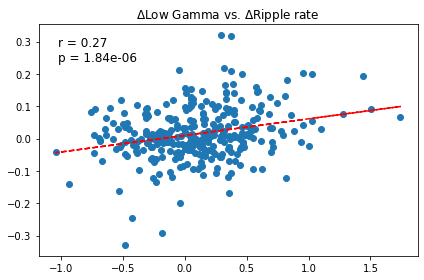

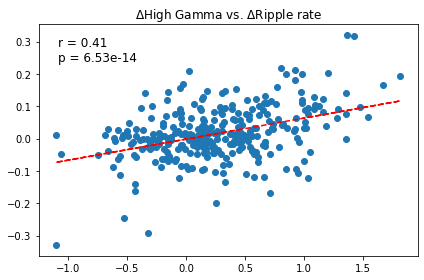

In [26]:
# delta(low gamma) vs. delta(ripple rate) (where both deltas are clust - unclust recalls)
correlation_coefficient, p_value = pearsonr(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)

plt.scatter(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)
plt.title(r"$\Delta$Low Gamma vs. $\Delta$Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')
# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff, 1)
fit_line = np.array(sub_low_gamma_elecs_clust_diff) * slope + intercept
plt.plot(sub_low_gamma_elecs_clust_diff, fit_line, color='red', linestyle='--', label='Linear fit')
plt.tight_layout(); plt.show()

# high gamma vs. ripple rate
correlation_coefficient, p_value = pearsonr(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)

plt.scatter(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)
plt.title(r"$\Delta$High Gamma vs. $\Delta$Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')
# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff, 1)
fit_line = np.array(sub_high_gamma_elecs_clust_diff) * slope + intercept
plt.plot(sub_high_gamma_elecs_clust_diff, fit_line, color='red', linestyle='--', label='Linear fit')
plt.tight_layout(); plt.show()

a=1;

# ripples after removing low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


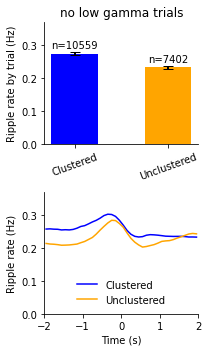

In [30]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.37)
trial_select = ~z_low_gamma_trials
    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('no low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

# ripples only for + low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


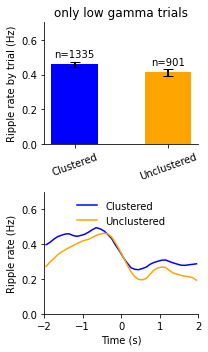

In [28]:
# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.7)
trial_select = z_low_gamma_trials

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('only low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='upper center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (sub_clust_ID > 1).astype(int),
    'clust_unclustered': (sub_clust_ID < 0).astype(int),
    'clust_not_recalled': (sub_clust_ID == 0).astype(int),
    'session': dd_trials['sess'][final_sub_idxs],
    'subject': dd_trials['subj'][final_sub_idxs],
    'low_gamma': z_low_gamma_trials,
    #'high_gamma': z_high_gamma_trials
})

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "ripple_rate ~ clust_clustered + clust_unclustered"
elif encoding_mode == 0:
    formula = "ripple_rate ~ clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ripple_rate
No. Observations: 20818   Method:             REML       
No. Groups:       99      Scale:              0.6035     
Min. group size:  3       Log-Likelihood:     -24505.6310
Max. group size:  3168    Converged:          Yes        
Mean group size:  210.3                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.469    0.022 21.671 0.000  0.427  0.511
clust_clustered 0.047    0.011  4.172 0.000  0.025  0.069
session Var     0.071    0.011                           



In [32]:
if encoding_mode == 1:
    formula = "ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    formula = "ripple_rate ~ low_gamma*clust_clustered" # since not recalled doesn't exist

model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ripple_rate
No. Observations:        20818         Method:                   REML       
No. Groups:              99            Scale:                    0.5949     
Min. group size:         3             Log-Likelihood:           -24360.8485
Max. group size:         3168          Converged:                Yes        
Mean group size:         210.3                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.436    0.022 20.110 0.000  0.393  0.478
low_gamma[T.True]                  0.305    0.027 11.399 0.000  0.252  0.357
clust_clustered                    0.046    0.012  3.948 0.000  0.023  0.069
low_gamma[T.True]:c